# Day 1: 指标复盘与数据脚手架

## 学习目标

- 统一常用指标的实现接口（MA/EMA/RSI/BB/ATR/MACD/Donchian/OBV）
- 检查数据完整性与 NaN 位置，准备好后续回测的数据脚手架
- 以 AAPL、SPY 演示指标可视化
- 产出基准指标表（买入持有的收益/波动/Sharpe/最大回撤）
- 导出对齐的数据集供 Day 2–7 使用

**目的**：搭建研究脚手架，验证指标计算正确与可视化清晰。

**金融含义**：量化研究的基础在于准确的数据与可靠的指标计算。本节建立标准化的研究工具链，为后续策略开发提供统一的技术分析框架。


### 1. 导入与参数设置

**目的**：导入必要库并设定研究标的与时间范围。

**金融含义**：标的选择（大盘股AAPL vs 市场指数SPY）与样本期设定直接影响研究结论的有效性和可推广性。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# 导入自定义库函数
import sys
sys.path.append('..')
from src.miniqlib import (
    fetch_price, simple_return, log_return, equity, perf, ensure_dir,
    sma, ema, rsi, bbands, atr, macd, donchian, obv
)

# 设定参数
TICKERS = ["AAPL", "SPY"]
START = "2015-01-01"

# 设置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print(f"研究标的: {TICKERS}")
print(f"样本起始: {START}")


研究标的: ['AAPL', 'SPY']
样本起始: 2015-01-01


### 2. 数据下载（AAPL / SPY）

**目的**：获取研究标的的OHLCV数据，检查数据完整性。

**金融含义**：数据质量是量化研究的生命线。缺失数据、停牌、除权除息等因素都会影响指标计算的准确性。


In [2]:
# 下载数据
data = {}
for ticker in TICKERS:
    print(f"\n下载 {ticker} 数据...")
    df = fetch_price(ticker, start=START)
    if df.empty:
        print(f"错误：{ticker} 数据下载失败，停止后续分析")
        break
    data[ticker] = df
    print(f"{ticker} 数据范围: {df.index[0].date()} 至 {df.index[-1].date()}")
    print(f"数据形状: {df.shape}")

# 检查数据是否完整
if len(data) != len(TICKERS):
    print("\n数据下载不完整，请检查网络连接或股票代码")
else:
    print("\n所有数据下载完成")
    
    # 显示数据概览
    for ticker in TICKERS:
        print(f"\n{ticker} 数据预览:")
        print(data[ticker].head(3))
        print("...")
        print(data[ticker].tail(3))



下载 AAPL 数据...
AAPL 数据范围: 2015-01-02 至 2025-09-09
数据形状: (2687, 5)

下载 SPY 数据...
SPY 数据范围: 2015-01-02 至 2025-09-09
数据形状: (2687, 5)

所有数据下载完成

AAPL 数据预览:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261047  24.729270  23.821672  24.718174  212818400
2015-01-05  23.577570  24.110146  23.391169  24.030260  257142000
2015-01-06  23.579796  23.839426  23.218087  23.641929  263188400
...
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-09-05  239.690002  241.320007  238.490005  240.000000  54870400
2025-09-08  237.880005  240.149994  236.339996  239.300003  48999500
2025-09-09  234.350006  238.779999  233.360001  237.000000  66153200

SPY 数据预览:
Price            Close 

### 3. 基本序列与基准表现（以AAPL为例）

**目的**：从价格序列计算收益率与净值曲线，建立绩效评价基准。

**金融含义**：简单收益与对数收益各有应用场景；复利净值反映长期投资表现；买入持有策略是所有主动策略的比较基准。


In [7]:
# 以AAPL为主要分析对象
aapl = data['AAPL']
px = aapl['Close']  # 收盘价序列

# 计算收益率
ret_simple = simple_return(px['AAPL'])
ret_log = log_return(px['AAPL'])

# 计算买入持有净值
eq_bh = equity(ret_simple)

# 计算基准绩效指标
bh_perf = perf(ret_simple)
print(bh_perf)

print("AAPL 买入持有策略绩效指标:")
print("-" * 30)
for key, value in bh_perf.items():
    if key == 'CAGR':
        print(f"{key:>8}: {value:.2%}")
    elif key == 'Vol':
        print(f"{key:>8}: {value:.2%}")
    elif key == 'Sharpe':
        print(f"{key:>8}: {value:.3f}")
    elif key == 'MaxDD':
        print(f"{key:>8}: {value:.2%}")

print(f"\n数据点数: {len(px)}")
print(f"起始价格: ${px['AAPL'].iloc[0]:.2f}")
print(f"结束价格: ${px['AAPL'].iloc[-1]:.2f}")
print(f"总回报: {(px['AAPL'].iloc[-1]/px['AAPL'].iloc[0] - 1):.2%}")


{'CAGR': 0.23701206723353896, 'Vol': 0.2905482075023924, 'Sharpe': 0.8774663983507955, 'MaxDD': -0.3851589562185903}
AAPL 买入持有策略绩效指标:
------------------------------
    CAGR: 23.70%
     Vol: 29.05%
  Sharpe: 0.877
   MaxDD: -38.52%

数据点数: 2687
起始价格: $24.26
结束价格: $234.35
总回报: 865.95%


### 4. 趋势指标：SMA/EMA（AAPL）

**目的**：计算并可视化简单移动平均与指数移动平均。

**金融含义**：移动平均是最基础的趋势跟踪指标，平滑价格波动但引入滞后性。EMA对近期价格敏感度更高，SMA更平滑稳定。


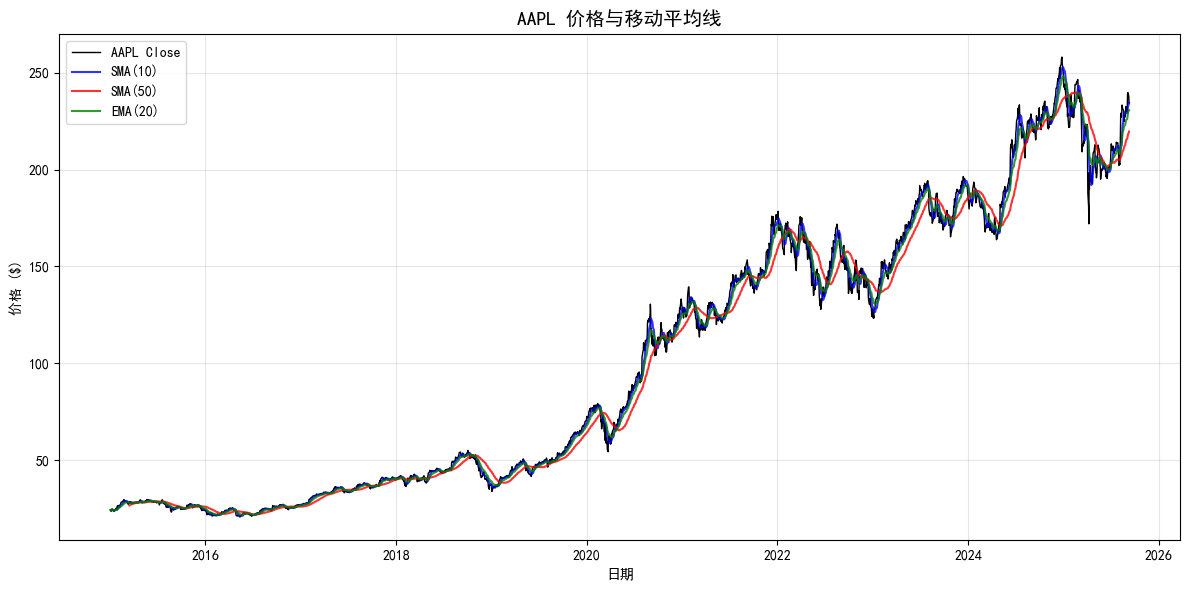

SMA(10) 前10个值的NaN数量: Ticker
AAPL    9
dtype: int64
SMA(50) 前50个值的NaN数量: Ticker
AAPL    49
dtype: int64
EMA(20) 前20个值的NaN数量: Ticker
AAPL    0
dtype: int64


In [8]:
# 计算移动平均线
sma10 = sma(px, 10)
sma50 = sma(px, 50)
ema20 = ema(px, 20)

# 绘制价格与均线
plt.figure(figsize=(12, 6))
plt.plot(px.index, px, label='AAPL Close', color='black', linewidth=1)
plt.plot(sma10.index, sma10, label='SMA(10)', color='blue', alpha=0.8)
plt.plot(sma50.index, sma50, label='SMA(50)', color='red', alpha=0.8)
plt.plot(ema20.index, ema20, label='EMA(20)', color='green', alpha=0.8)

plt.title('AAPL 价格与移动平均线', fontsize=14)
plt.xlabel('日期')
plt.ylabel('价格 ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 检查NaN情况
print(f"SMA(10) 前10个值的NaN数量: {sma10.head(10).isna().sum()}")
print(f"SMA(50) 前50个值的NaN数量: {sma50.head(50).isna().sum()}")
print(f"EMA(20) 前20个值的NaN数量: {ema20.head(20).isna().sum()}")


### 5. 布林带（AAPL）

**目的**：计算布林带指标，观察价格相对于动态波动区间的位置。

**金融含义**：布林带结合了趋势（中轨）与波动率（带宽）信息。价格触及上下轨常被视为超买/超卖信号，带宽收缩预示波动率突破。


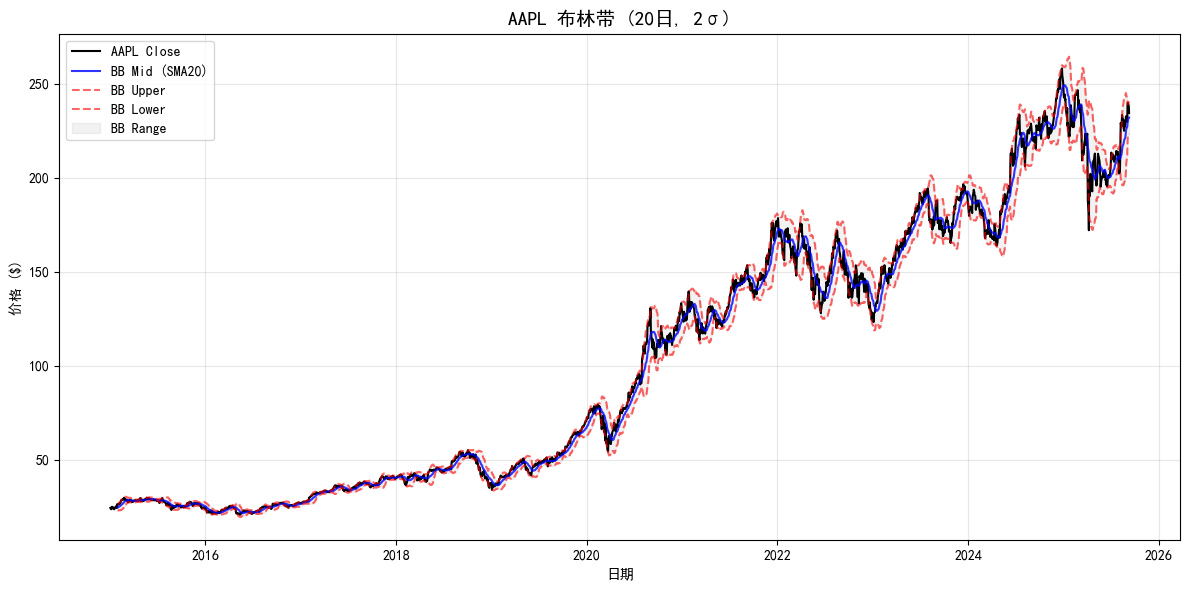

[192]
价格突破上轨次数: 192 (7.1%)
价格跌破下轨次数: 121 (4.5%)
布林带宽度均值: 3.04


In [ ]:
# 计算布林带
bb_mid, bb_up, bb_dn, bb_std = bbands(px, window=20, num_std=2.0)

# 绘制布林带
plt.figure(figsize=(12, 6))
plt.plot(px['AAPL'].index, px['AAPL'], label='AAPL Close', color='black', linewidth=1.5)
plt.plot(bb_mid['AAPL'].index, bb_mid['AAPL'], label='BB Mid (SMA20)', color='blue', alpha=0.8)
plt.plot(bb_up['AAPL'].index, bb_up['AAPL'], label='BB Upper', color='red', alpha=0.6, linestyle='--')
plt.plot(bb_dn['AAPL'].index, bb_dn['AAPL'], label='BB Lower', color='red', alpha=0.6, linestyle='--')
plt.fill_between(bb_up['AAPL'].index, bb_up['AAPL'], bb_dn['AAPL'], alpha=0.1, color='gray', label='BB Range')

plt.title('AAPL 布林带 (20日, 2σ)', fontsize=14)
plt.xlabel('日期')
plt.ylabel('价格 ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 统计价格突破情况
above_upper = (px > bb_up).sum()
print(above_upper.values)
below_lower = (px < bb_dn).sum()
total_days = len(px.dropna())

print(f"价格突破上轨次数: {above_upper.values[0]} ({above_upper.values[0]/total_days:.1%})")
print(f"价格跌破下轨次数: {below_lower.values[0]} ({below_lower.values[0]/total_days:.1%})")
print(f"布林带宽度均值: {bb_std['AAPL'].mean():.2f}")


### 6. RSI（AAPL）

**目的**：计算相对强弱指标，识别潜在的超买超卖区域。

**金融含义**：RSI基于涨跌幅度比较，反映价格动量强弱。传统上RSI>70视为超买，RSI<30视为超卖，但在强趋势中可能持续极值。


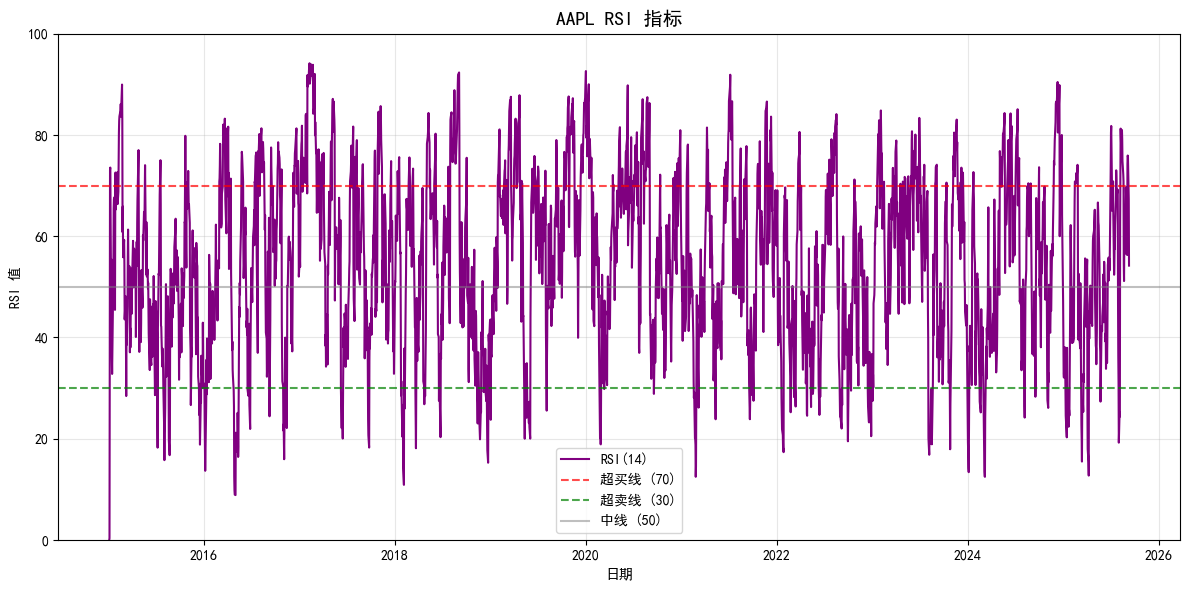

RSI > 70 (超买) 天数: 622 (23.2%)
RSI < 30 (超卖) 天数: 219 (8.2%)
RSI 均值: 55.3
RSI 标准差: 17.3


In [23]:
# 计算RSI
rsi14 = rsi(px, period=14)

# 绘制RSI
plt.figure(figsize=(12, 6))
plt.plot(rsi14.index, rsi14, label='RSI(14)', color='purple', linewidth=1.5)
plt.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='超买线 (70)')
plt.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='超卖线 (30)')
plt.axhline(y=50, color='gray', linestyle='-', alpha=0.5, label='中线 (50)')

plt.title('AAPL RSI 指标', fontsize=14)
plt.xlabel('日期')
plt.ylabel('RSI 值')
plt.ylim(0, 100)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# RSI统计
rsi_clean = rsi14.dropna()
overbought = (rsi_clean > 70).sum()
oversold = (rsi_clean < 30).sum()
total_valid = len(rsi_clean)

print(f"RSI > 70 (超买) 天数: {overbought.values[0]} ({overbought.values[0]/total_valid:.1%})")
print(f"RSI < 30 (超卖) 天数: {oversold.values[0]} ({oversold.values[0]/total_valid:.1%})")
print(f"RSI 均值: {rsi_clean.values.mean():.1f}")
print(f"RSI 标准差: {rsi_clean.values.std():.1f}")


### 7. ATR 与 Donchian（AAPL）

**目的**：计算真实波动幅度与唐奇安通道，衡量市场波动性与突破信号。

**金融含义**：ATR反映市场波动程度，常用于动态止损设定；Donchian通道基于最高最低价，是经典的突破交易工具。


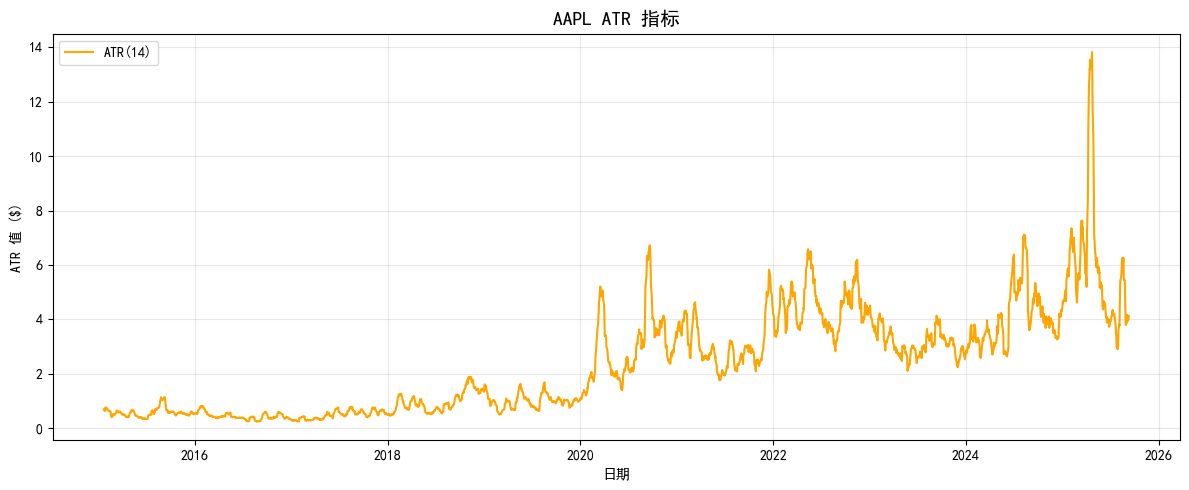

ATR 均值: $2.38
ATR 标准差: $1.93
ATR 最大值: $13.82
ATR 最小值: $0.25


In [24]:
# 计算ATR
atr14 = atr(aapl['High'], aapl['Low'], aapl['Close'], period=14)

# 绘制ATR
plt.figure(figsize=(12, 5))
plt.plot(atr14.index, atr14, label='ATR(14)', color='orange', linewidth=1.5)
plt.title('AAPL ATR 指标', fontsize=14)
plt.xlabel('日期')
plt.ylabel('ATR 值 ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ATR 均值: ${atr14.mean():.2f}")
print(f"ATR 标准差: ${atr14.std():.2f}")
print(f"ATR 最大值: ${atr14.max():.2f}")
print(f"ATR 最小值: ${atr14.min():.2f}")


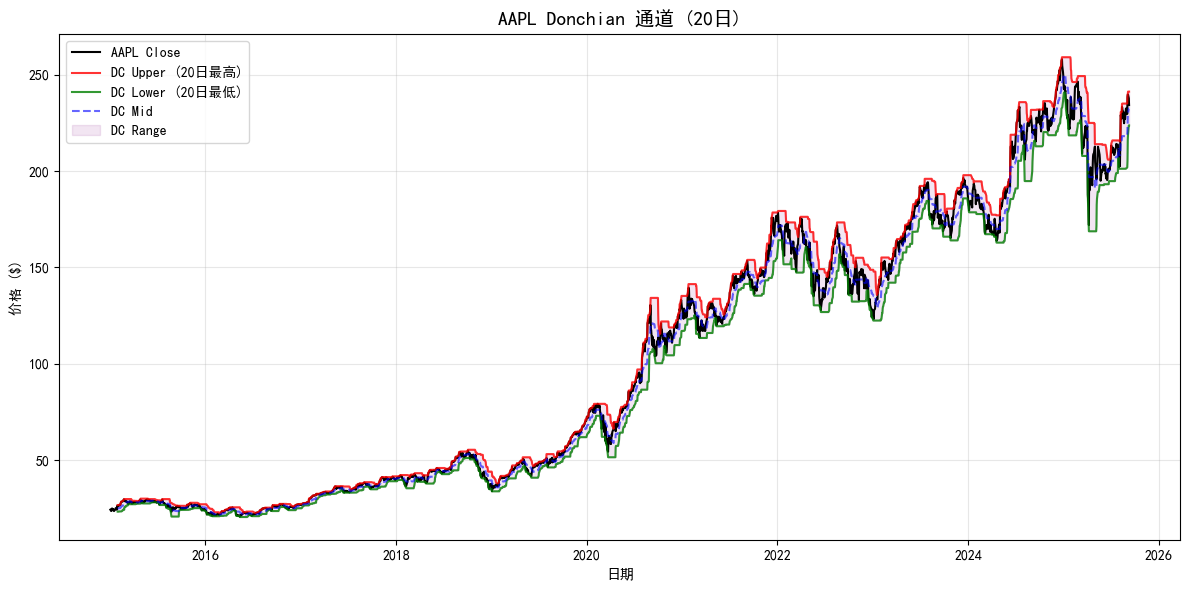

向上突破次数: 5 (0.2%)
向下突破次数: 2 (0.1%)


In [30]:
# 计算Donchian通道
dc_up, dc_dn, dc_mid = donchian(aapl['High'], aapl['Low'], window=20)

# 绘制Donchian通道
plt.figure(figsize=(12, 6))
plt.plot(px.index, px, label='AAPL Close', color='black', linewidth=1.5)
plt.plot(dc_up.index, dc_up, label='DC Upper (20日最高)', color='red', alpha=0.8)
plt.plot(dc_dn.index, dc_dn, label='DC Lower (20日最低)', color='green', alpha=0.8)
plt.plot(dc_mid.index, dc_mid, label='DC Mid', color='blue', alpha=0.6, linestyle='--')
plt.fill_between(dc_up.index, dc_up['AAPL'], dc_dn['AAPL'], alpha=0.1, color='purple', label='DC Range')

plt.title('AAPL Donchian 通道 (20日)', fontsize=14)
plt.xlabel('日期')
plt.ylabel('价格 ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 突破统计
breakout_up = (px >= dc_up).sum()
breakout_down = (px <= dc_dn).sum()
total_days = len(px.dropna())


print(f"向上突破次数: {breakout_up.values[0]} ({breakout_up.values[0]/total_days:.1%})")
print(f"向下突破次数: {breakout_down.values[0]} ({breakout_down.values[0]/total_days:.1%})")


### 8. MACD 与 OBV（AAPL）

**目的**：计算MACD动量指标与能量潮指标，分析价格动量变化与量价关系。

**金融含义**：MACD通过双EMA差值捕捉动量转换点，柱状图显示动量加速度；OBV将成交量按价格方向累积，反映资金流向。


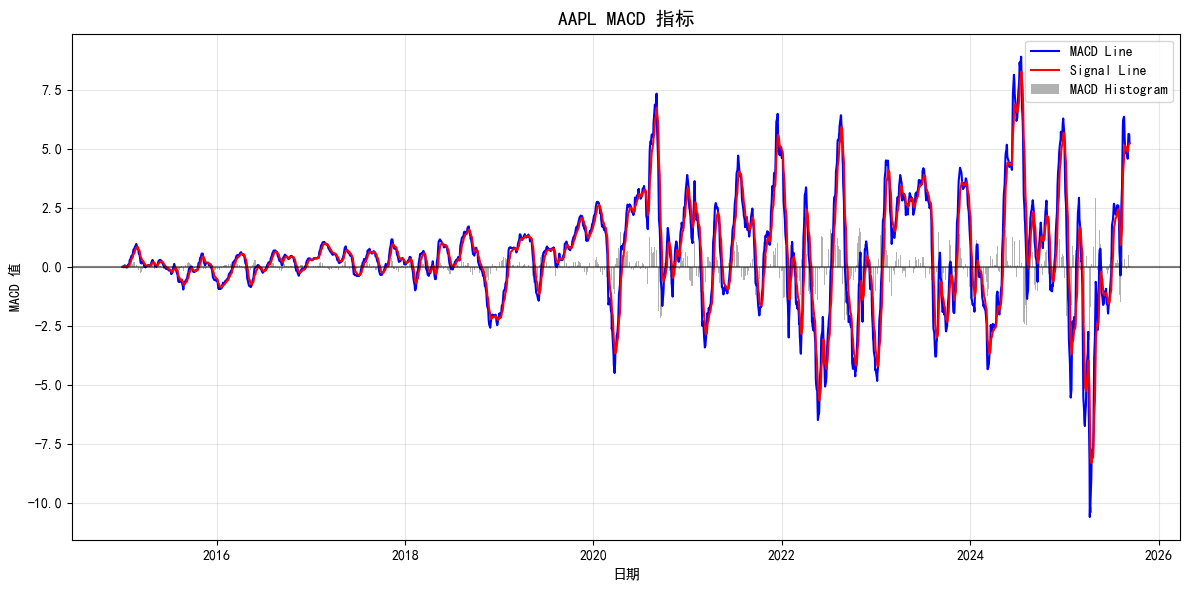

MACD > 0 天数: 1725 (64.2%)
金叉次数 (MACD上穿Signal): 96


In [35]:
# 计算MACD
macd_line, macd_signal, macd_hist = macd(px, fast=12, slow=26, signal=9)

# 绘制MACD
plt.figure(figsize=(12, 6))
plt.plot(macd_line.index, macd_line, label='MACD Line', color='blue', linewidth=1.5)
plt.plot(macd_signal.index, macd_signal, label='Signal Line', color='red', linewidth=1.5)
plt.bar(macd_hist.index, macd_hist['AAPL'], label='MACD Histogram', color='gray', alpha=0.6, width=1)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.title('AAPL MACD 指标', fontsize=14)
plt.xlabel('日期')
plt.ylabel('MACD 值')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# MACD统计
macd_above_zero = (macd_line > 0).sum()
signal_crossover = ((macd_line > macd_signal) & (macd_line.shift(1) <= macd_signal.shift(1))).sum()

print(f"MACD > 0 天数: {macd_above_zero.values[0]} ({macd_above_zero.values[0]/len(macd_line):.1%})")
print(f"金叉次数 (MACD上穿Signal): {signal_crossover.values[0]}")


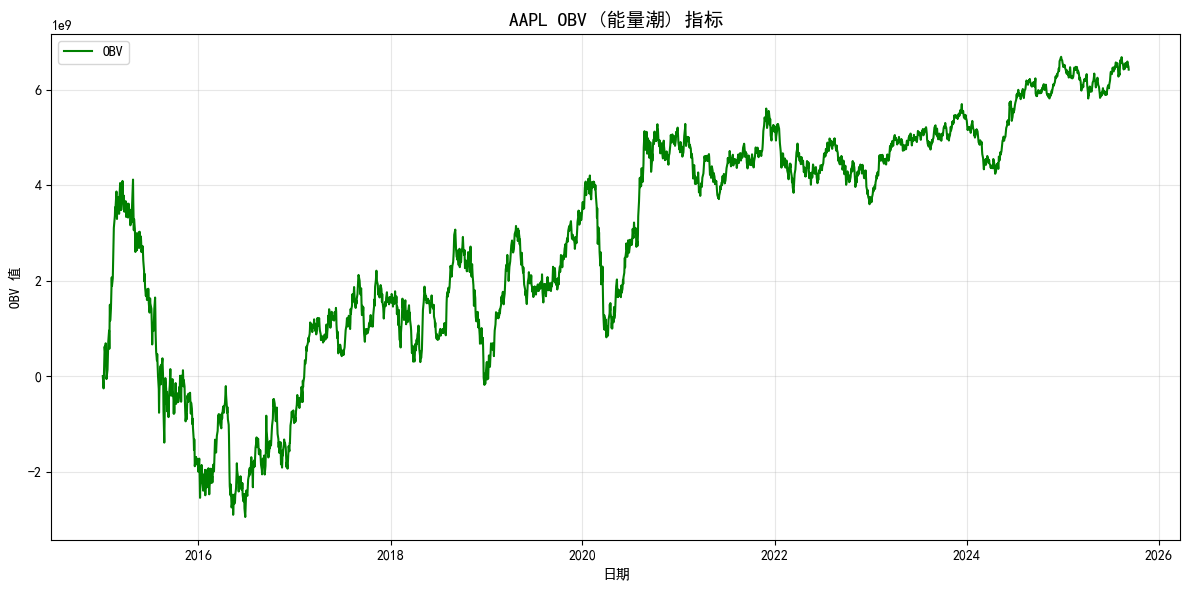

OBV与价格相关系数: nan
OBV变化率 (首末比): -2599.1%


c:\Users\zyf17\anaconda3\envs\quant_clean\lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\zyf17\anaconda3\envs\quant_clean\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\zyf17\anaconda3\envs\quant_clean\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [41]:
# 计算OBV
obv_series = obv(px, aapl['Volume'])

# 绘制OBV
plt.figure(figsize=(12, 6))
plt.plot(obv_series.index, obv_series, label='OBV', color='green', linewidth=1.5)
plt.title('AAPL OBV (能量潮) 指标', fontsize=14)
plt.xlabel('日期')
plt.ylabel('OBV 值')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# OBV与价格相关性
obv_clean = obv_series.dropna()
px_clean = px.loc[obv_clean.index]
correlation = np.corrcoef(obv_clean, px_clean)[0, 1]

print(f"OBV与价格相关系数: {correlation:.3f}")
print(f"OBV变化率 (首末比): {(obv_clean['AAPL'].iloc[-1]/obv_clean['AAPL'].iloc[1] - 1):.1%}")


### 9. 跨标的快速检查（SPY）

**目的**：对SPY应用相同指标，验证算法一致性与跨资产特征差异。

**金融含义**：指标在不同资产类别的表现差异反映市场结构特点；ETF相比个股通常波动更小、趋势更稳定。


In [43]:
data

{'AAPL': Price            Close        High         Low        Open     Volume
 Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
 Date                                                                 
 2015-01-02   24.261047   24.729270   23.821672   24.718174  212818400
 2015-01-05   23.577570   24.110146   23.391169   24.030260  257142000
 2015-01-06   23.579796   23.839426   23.218087   23.641929  263188400
 2015-01-07   23.910433   24.010290   23.677430   23.788384  160423600
 2015-01-08   24.829124   24.886821   24.121242   24.238854  237458000
 ...                ...         ...         ...         ...        ...
 2025-09-03  238.470001  238.850006  234.360001  237.210007   66427800
 2025-09-04  239.779999  239.899994  236.740005  238.449997   47549400
 2025-09-05  239.690002  241.320007  238.490005  240.000000   54870400
 2025-09-08  237.880005  240.149994  236.339996  239.300003   48999500
 2025-09-09  234.350006  238.779999  233.360001  237.000000   6615320

In [46]:
# SPY数据处理
spy = data['SPY']
spy_px = spy['Close']
spy_ret = simple_return(spy_px['SPY'])

# SPY基准绩效
spy_perf = perf(spy_ret)

print("SPY vs AAPL 绩效对比:")
print("-" * 40)
print(f"{'指标':<8} {'SPY':<10} {'AAPL':<10}")
print("-" * 40)
for key in ['CAGR', 'Vol', 'Sharpe', 'MaxDD']:
    if key in ['CAGR', 'Vol', 'MaxDD']:
        print(f"{key:<8} {spy_perf[key]:<10.2%} {bh_perf[key]:<10.2%}")
    else:
        print(f"{key:<8} {spy_perf[key]:<10.3f} {bh_perf[key]:<10.3f}")


SPY vs AAPL 绩效对比:
----------------------------------------
指标       SPY        AAPL      
----------------------------------------
CAGR     13.31%     23.70%    
Vol      17.94%     29.05%    
Sharpe   0.787      0.877     
MaxDD    -33.72%    -38.52%   


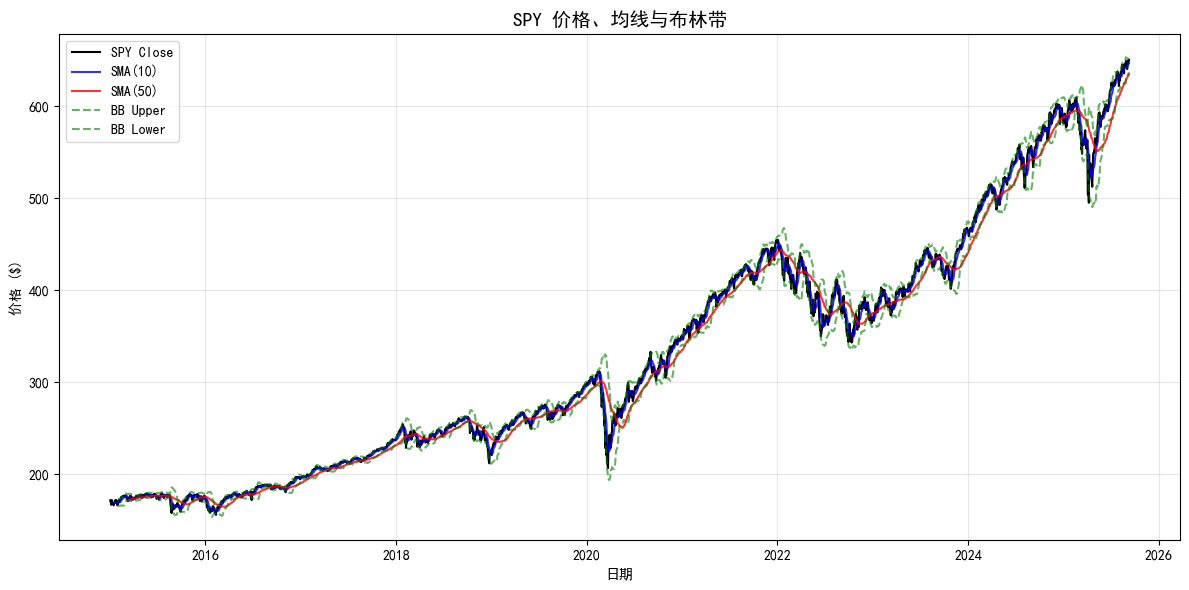

In [47]:
# SPY指标计算
spy_sma10 = sma(spy_px, 10)
spy_sma50 = sma(spy_px, 50)
spy_bb_mid, spy_bb_up, spy_bb_dn, _ = bbands(spy_px, window=20)

# SPY均线+布林带图
plt.figure(figsize=(12, 6))
plt.plot(spy_px.index, spy_px, label='SPY Close', color='black', linewidth=1.5)
plt.plot(spy_sma10.index, spy_sma10, label='SMA(10)', color='blue', alpha=0.8)
plt.plot(spy_sma50.index, spy_sma50, label='SMA(50)', color='red', alpha=0.8)
plt.plot(spy_bb_up.index, spy_bb_up, label='BB Upper', color='green', alpha=0.6, linestyle='--')
plt.plot(spy_bb_dn.index, spy_bb_dn, label='BB Lower', color='green', alpha=0.6, linestyle='--')

plt.title('SPY 价格、均线与布林带', fontsize=14)
plt.xlabel('日期')
plt.ylabel('价格 ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


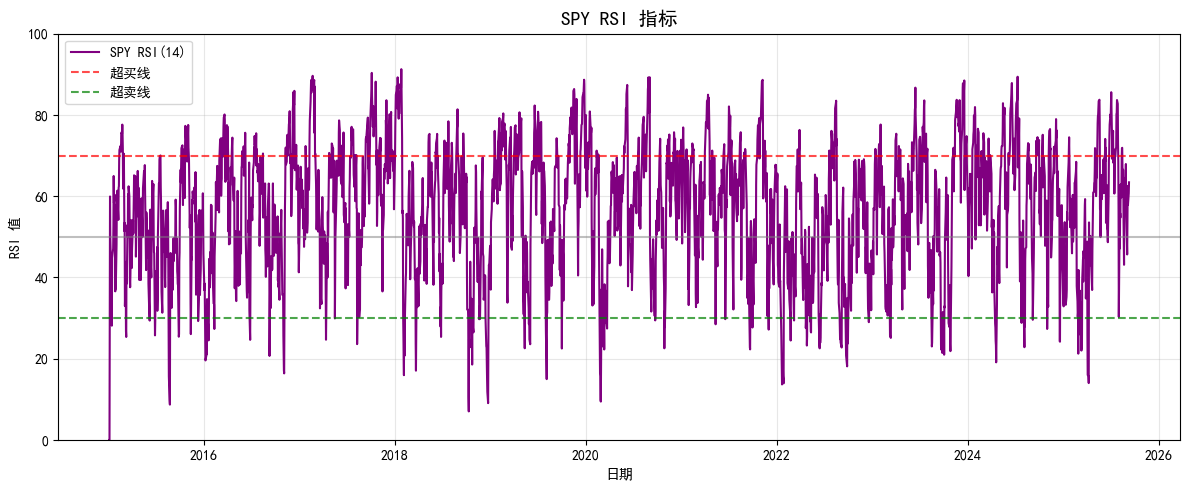


RSI特征对比:
SPY RSI 均值: 56.9 vs AAPL: 55.3
SPY RSI 标准差: 15.8 vs AAPL: 17.3


In [49]:
# SPY RSI
spy_rsi = rsi(spy_px, period=14)

plt.figure(figsize=(12, 5))
plt.plot(spy_rsi.index, spy_rsi, label='SPY RSI(14)', color='purple', linewidth=1.5)
plt.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='超买线')
plt.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='超卖线')
plt.axhline(y=50, color='gray', linestyle='-', alpha=0.5)

plt.title('SPY RSI 指标', fontsize=14)
plt.xlabel('日期')
plt.ylabel('RSI 值')
plt.ylim(0, 100)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# SPY与AAPL RSI特征对比
spy_rsi_clean = spy_rsi.dropna()
print(f"\nRSI特征对比:")
print(f"SPY RSI 均值: {spy_rsi_clean['SPY'].mean():.1f} vs AAPL: {rsi_clean['AAPL'].mean():.1f}")
print(f"SPY RSI 标准差: {spy_rsi_clean['SPY'].std():.1f} vs AAPL: {rsi_clean['AAPL'].std():.1f}")


### 10. 导出与留档

**目的**：整理并保存关键指标数据，为后续策略回测提供标准化输入。

**金融含义**：数据标准化与版本管理是量化研究的重要环节，确保策略复现性与结果可追溯性。


In [58]:
atr14

Date
2015-01-02         NaN
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
                ...   
2025-09-03    4.167858
2025-09-04    4.088572
2025-09-05    3.937857
2025-09-08    3.995001
2025-09-09    4.130716
Length: 2687, dtype: float64

In [59]:
# 确保数据目录存在
ensure_dir("../data")

# 整理AAPL指标数据
indicators_df = pd.DataFrame({
    'Close': px['AAPL'],
    'ret_simple': ret_simple,
    'sma10': sma10['AAPL'],
    'sma50': sma50['AAPL'],
    'ema20': ema20['AAPL'],
    'rsi14': rsi14['AAPL'],
    'bb_mid': bb_mid['AAPL'],
    'bb_up': bb_up['AAPL']  ,
    'bb_dn': bb_dn['AAPL'],
    'atr14': atr14,
    'macd_line': macd_line['AAPL'],
    'macd_signal': macd_signal['AAPL'],
    'macd_hist': macd_hist['AAPL'],
    'dc_up': dc_up['AAPL'],
    'dc_dn': dc_dn['AAPL'],
    'dc_mid': dc_mid['AAPL'],
    'obv': obv_series['AAPL']
}, index=px.index)

# 保存到parquet文件
output_path = "../data/day1_indicators.parquet"
indicators_df.to_parquet(output_path)

print(f"数据已保存至: {output_path}")
print(f"数据形状: {indicators_df.shape}")
print(f"\n列名: {list(indicators_df.columns)}")

# 检查缺失值情况
print(f"\n各列缺失值统计:")
missing_count = indicators_df.isnull().sum()
for col, count in missing_count.items():
    if count > 0:
        print(f"{col}: {count} ({count/len(indicators_df):.1%})")

print(f"\n完整数据范围: {indicators_df.dropna().index[0].date()} 至 {indicators_df.dropna().index[-1].date()}")
print(f"完整数据点数: {len(indicators_df.dropna())}")


数据已保存至: ../data/day1_indicators.parquet
数据形状: (2687, 17)

列名: ['Close', 'ret_simple', 'sma10', 'sma50', 'ema20', 'rsi14', 'bb_mid', 'bb_up', 'bb_dn', 'atr14', 'macd_line', 'macd_signal', 'macd_hist', 'dc_up', 'dc_dn', 'dc_mid', 'obv']

各列缺失值统计:
sma10: 9 (0.3%)
sma50: 49 (1.8%)
rsi14: 1 (0.0%)
bb_mid: 19 (0.7%)
bb_up: 19 (0.7%)
bb_dn: 19 (0.7%)
atr14: 13 (0.5%)
dc_up: 19 (0.7%)
dc_dn: 19 (0.7%)
dc_mid: 19 (0.7%)

完整数据范围: 2015-03-16 至 2025-09-09
完整数据点数: 2638


## 要点小结

### 关键学习要点

- **指标分类**：趋势类（MA/EMA）、波动类（BB/ATR）、震荡类（RSI/MACD）、量能类（OBV）各有不同应用场景

- **滞后性权衡**：所有技术指标都存在滞后性，平滑参数越大滞后越明显，需要在信号及时性与噪声过滤间平衡

- **数据质量基础**：NaN处理、除权除息、数据对齐是后续回测准确性的前提，前期数据不足会影响指标计算

- **跨资产差异**：个股（AAPL）vs 指数（SPY）在波动率、趋势持续性、极值频率等方面存在系统性差异

- **下一步准备**：今日建立的数据脚手架与指标库将为明日开始的交易信号生成与回测提供标准化输入

### 技术要点

- **函数式设计**：miniqlib采用函数式设计，便于模块化调用与后续扩展
- **向量化计算**：所有指标均基于pandas向量化操作，计算效率较高
- **边界处理**：窗口期前的NaN值保留，由上层逻辑统一处理，避免不一致的填充策略
